# Import Library

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, VisualRepresentation
from bertopic.backend import MultiModalBackend
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from umap import UMAP
import hdbscan
import base64
from io import BytesIO
from IPython.display import HTML

# Process Datasets

In [7]:
TRAIN_FOLDER = 'Datasets/RawData/train'
TEST_FOLDER = 'Datasets/RawData/test'
VALID_FOLDER = 'Datasets/RawData/valid'

In [5]:
def load_image_paths_and_annotations(image_folder: str, annotation_file: str) -> tuple:
    """
    Load image paths and annotations.
    :param image_folder: Folder containing the images.
    :param annotation_file: CSV file containing the annotations.
    :return: Tuple containing a list of image paths and a pandas DataFrame containing the annotations.
    """
    annotations = pd.read_csv(annotation_file)
    image_paths = []
    labels = []

    for _, row in tqdm(annotations.iterrows(), total=annotations.shape[0], desc='Loading image paths'):
        try:
            img_filename = row['filename']
            img_path = os.path.join(image_folder, img_filename)
            if os.path.exists(img_path):
                image_paths.append(img_path)
                labels.append(row['class'])
            else:
                print(f'Image file {img_filename} does not exist at {img_path}')
        except Exception as e:
            print(f'Error processing image {img_filename}: {e}')
            continue

    return image_paths, labels, annotations

def image_base64(im: str) -> str:
    """
    Convert an image to base64.
    :param im: Path to the image.
    :return: Base64 encoding of the image.
    """
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im: str) -> str:
    """
    Display an image in a Jupyter notebook.
    :param im: Path to the image.
    :return: HTML image tag.
    """
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [8]:
test_images, test_labels, test_annotations = load_image_paths_and_annotations(TEST_FOLDER, os.path.join(TEST_FOLDER, '_annotations.csv'))
val_images, val_labels, val_annotations = load_image_paths_and_annotations(VALID_FOLDER, os.path.join(VALID_FOLDER, '_annotations.csv'))
train_images, train_labels, train_annotations = load_image_paths_and_annotations(TRAIN_FOLDER, os.path.join(TRAIN_FOLDER, '_annotations.csv'))

Loading image paths: 100%|██████████| 369/369 [00:00<00:00, 2571.11it/s]


Image file cocaine-powder-lines-rolled-banknote-and-drugs-in-plastic-bag-pocket-on-black-glass-surface-background-top-view-drug-addiction-concept-2NTT1Y1_jpg.rf.bf560732a757cb000614866c7fa8fc30.jpg does not exist at Datasets/RawData/test\cocaine-powder-lines-rolled-banknote-and-drugs-in-plastic-bag-pocket-on-black-glass-surface-background-top-view-drug-addiction-concept-2NTT1Y1_jpg.rf.bf560732a757cb000614866c7fa8fc30.jpg


Loading image paths:  28%|██▊       | 748/2631 [00:00<00:00, 3686.11it/s]

Image file drugs-narcotics-business-concept-cocaine-plastic-packets-gun-us-dollars-banknotes-table-white-powder-addiction-crime_771335-12925_jpg.rf.4c4ad70061bde378530068b3c0e43156.jpg does not exist at Datasets/RawData/train\drugs-narcotics-business-concept-cocaine-plastic-packets-gun-us-dollars-banknotes-table-white-powder-addiction-crime_771335-12925_jpg.rf.4c4ad70061bde378530068b3c0e43156.jpg


Loading image paths: 100%|██████████| 2631/2631 [00:00<00:00, 3933.91it/s]

Image file drugs-and-dollars-on-glass-black-table-narcotic-powder-divided-into-stripes-on-a-mirrored-table-one-hundred-dollar-tube-for-drug-use-2FMY1GY_jpg.rf.c501c958fefe6e5f2ced1d5d7ffd6231.jpg does not exist at Datasets/RawData/train\drugs-and-dollars-on-glass-black-table-narcotic-powder-divided-into-stripes-on-a-mirrored-table-one-hundred-dollar-tube-for-drug-use-2FMY1GY_jpg.rf.c501c958fefe6e5f2ced1d5d7ffd6231.jpg


In [10]:
images = train_images + test_images + val_images
labels = train_labels + test_labels + val_labels

# Prepare Model

## Pre-Compute embeddings

In [ ]:
'''
embedding_model = MultiModalBackend('clip-ViT-B-32', batch_size=32)
embedd = embedding_model.embed(documents=labels, images=images, verbose=True)
embedd_only_images = embedding_model.embed_images(images=images, verbose=True)
np.savez_compressed('Embeddings/embedding_images.npz', embedd)
np.savez_compressed('Embeddings/embedding_only_images.npz', embedd_only_images)
'''

In [11]:
with np.load('Embeddings/embedding_only_images.npz') as data1, np.load('Embeddings/embedding_images.npz') as data2:
    embedd_only_images = data1['arr_0']
    embedd = data2['arr_0']

## Build BERTopic Model

In [24]:
kw = KeyBERTInspired()
vectorizer_model = CountVectorizer(stop_words="english")
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
umap_model = UMAP(n_neighbors=100, n_components=10, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=50, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Embeddings image models
embedding_model = MultiModalBackend('clip-ViT-B-32', batch_size=32)

# Visual model
visual_model = VisualRepresentation(image_to_text_model="nlpconnect/vit-gpt2-image-captioning", nr_samples=20, nr_repr_images=500, image_height=800)

representation_model = {
   "Visual_Aspect":  visual_model,
   "KeyBERTInspired": kw
}

topic_model = BERTopic(
                      min_topic_size=50,
                      top_n_words=5,
                      n_gram_range=(1, 3),
                      representation_model=representation_model,
                      vectorizer_model=vectorizer_model,
                      ctfidf_model=ctfidf_model,
                      embedding_model=embedding_model,
                      umap_model=umap_model,
                      hdbscan_model=hdbscan_model,
                      verbose=True)

topics, probs = topic_model.fit_transform(documents=labels, images=images, embeddings=embedd_only_images)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
2024-08-26 12:42:14,316 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-26 12:42:50,827 - BERTopic - Dimensionality - Completed ✓
2024-08-26 12:42:50,837 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-26 12:42:51,167 - BERTopic - Cluster - Completed ✓
2024-08-26 12:42:51,237 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 5/5 [00:01<00:00,  4.87it/s]
2024-08-26 12:42:53,017 - BERTopic - Representation - Completed ✓


# Show Results

In [25]:
topic_model.topic_aspects_["Visual_Aspect"]

{-1: <PIL.Image.Image image mode=RGB size=408x800>,
 0: <PIL.Image.Image image mode=RGB size=320x800>,
 1: <PIL.Image.Image image mode=RGB size=409x800>,
 2: <PIL.Image.Image image mode=RGB size=326x800>,
 3: <PIL.Image.Image image mode=RGB size=319x800>}

,Topic,Count,KeyBERTInspired,Visual_Aspect
0,-1,134,"[drug, people, , , , , , , , ]",
1,0,2701,"[gun, , , , , , , , , ]",
2,1,429,"[drug, , , , , , , , , ]",
3,2,370,"[people, , , , , , , , , ]",
4,3,93,"[people, drug, , , , , , , , ]",

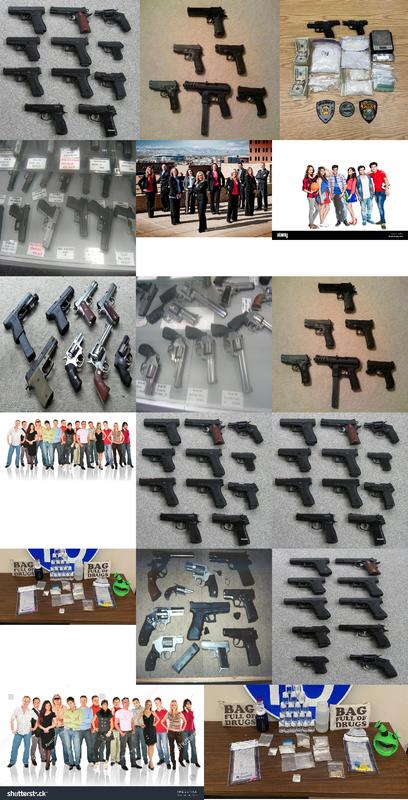
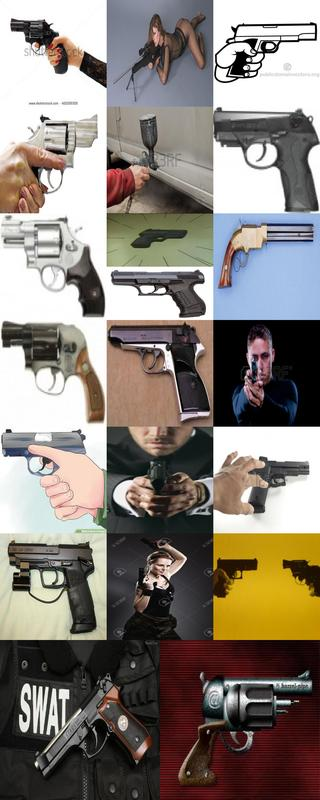
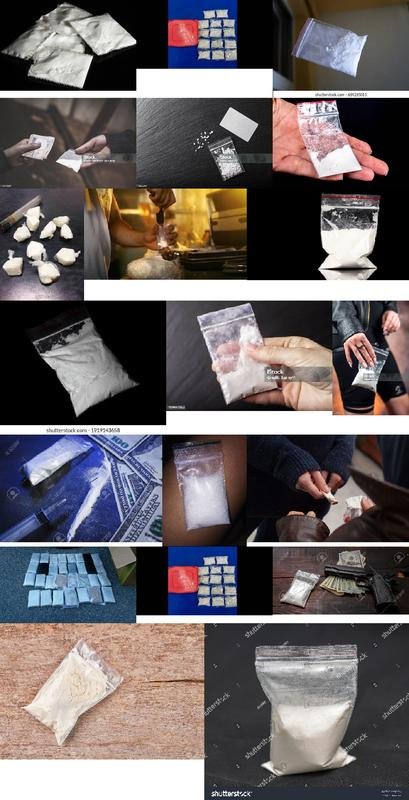
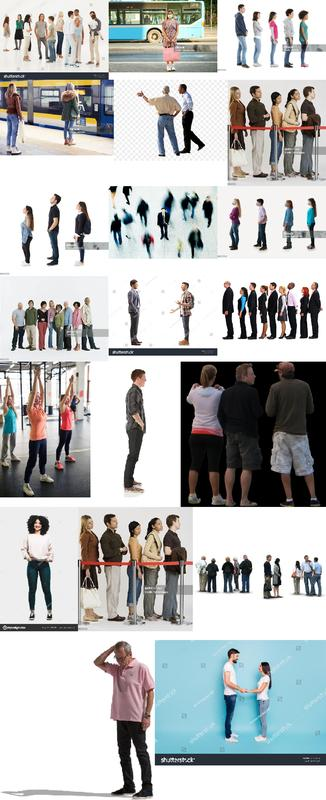
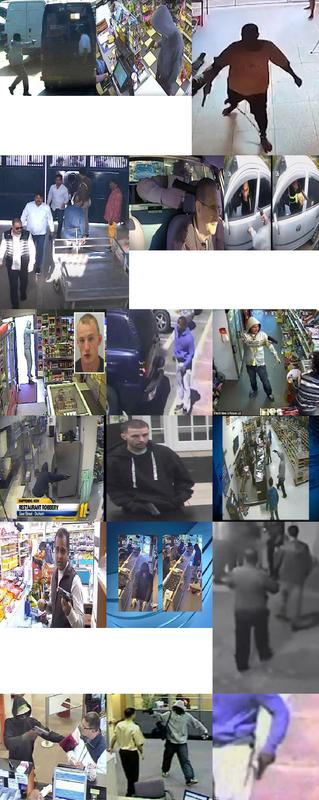

In [26]:
# Extract dataframe
df = topic_model.get_topic_info().drop(["Representative_Docs", "Name", "Representation"], axis=1)[["Topic", "Count", "KeyBERTInspired", "Visual_Aspect"]]

# Visualize the images
HTML(df.to_html(formatters={'Visual_Aspect': image_formatter}, escape=False))

# Model Graphs

In [35]:
topic_model.visualize_barchart()

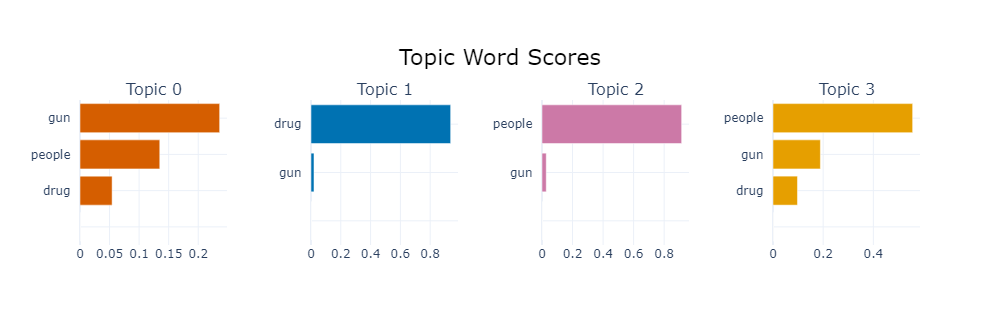

In [27]:
topic_model.visualize_topics()

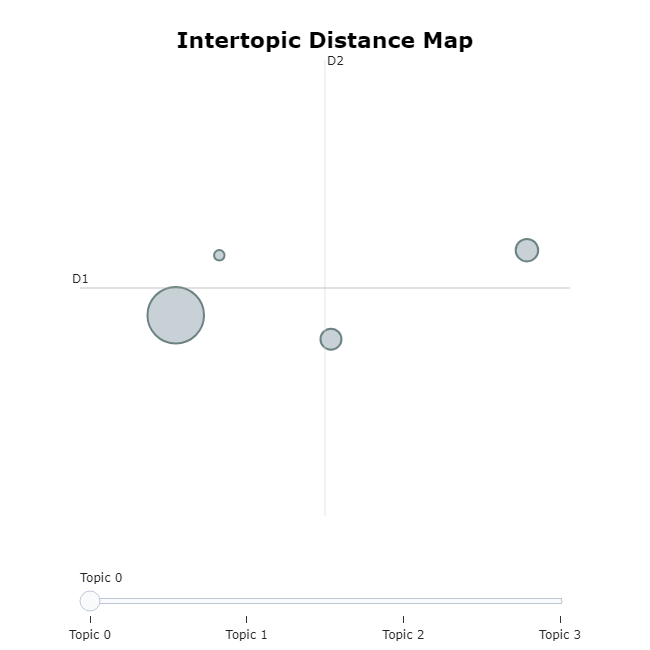

In [28]:
topic_model.visualize_heatmap()

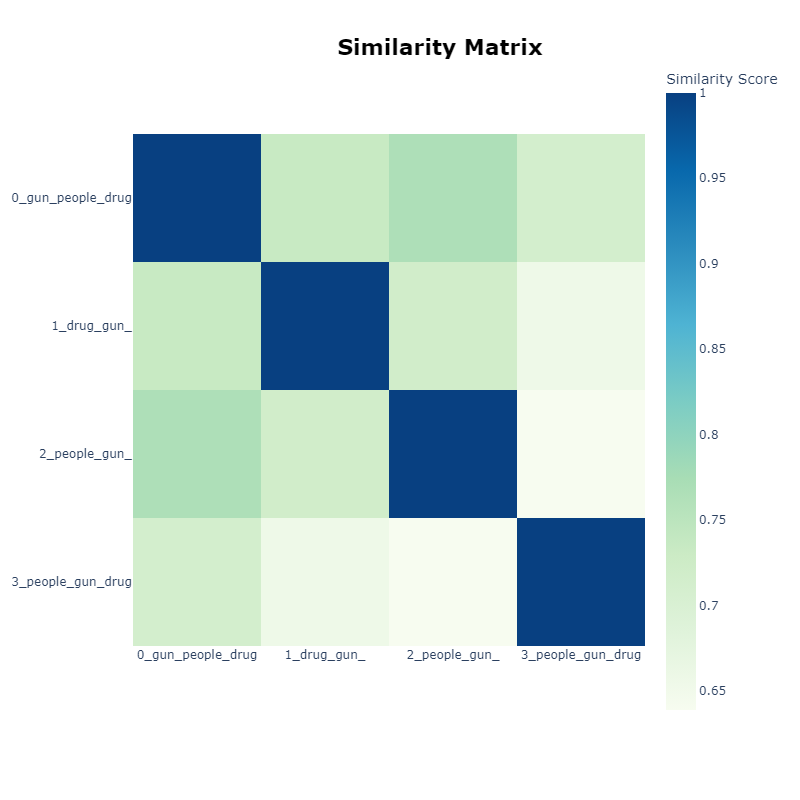

In [37]:
topic_model.visualize_hierarchy()

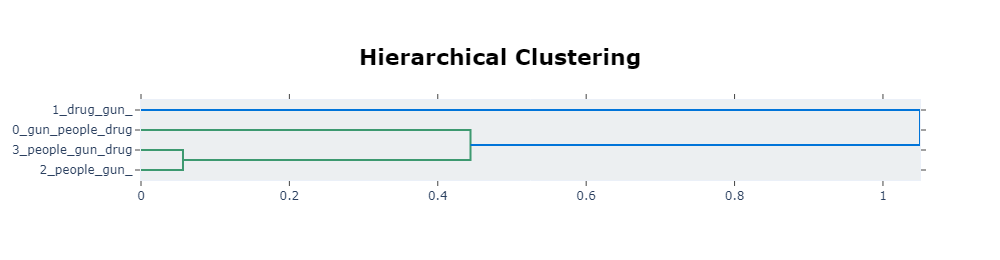

In [30]:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embedd)

In [33]:
topic_model.visualize_documents(labels, reduced_embeddings=reduced_embeddings, hide_document_hover=True)

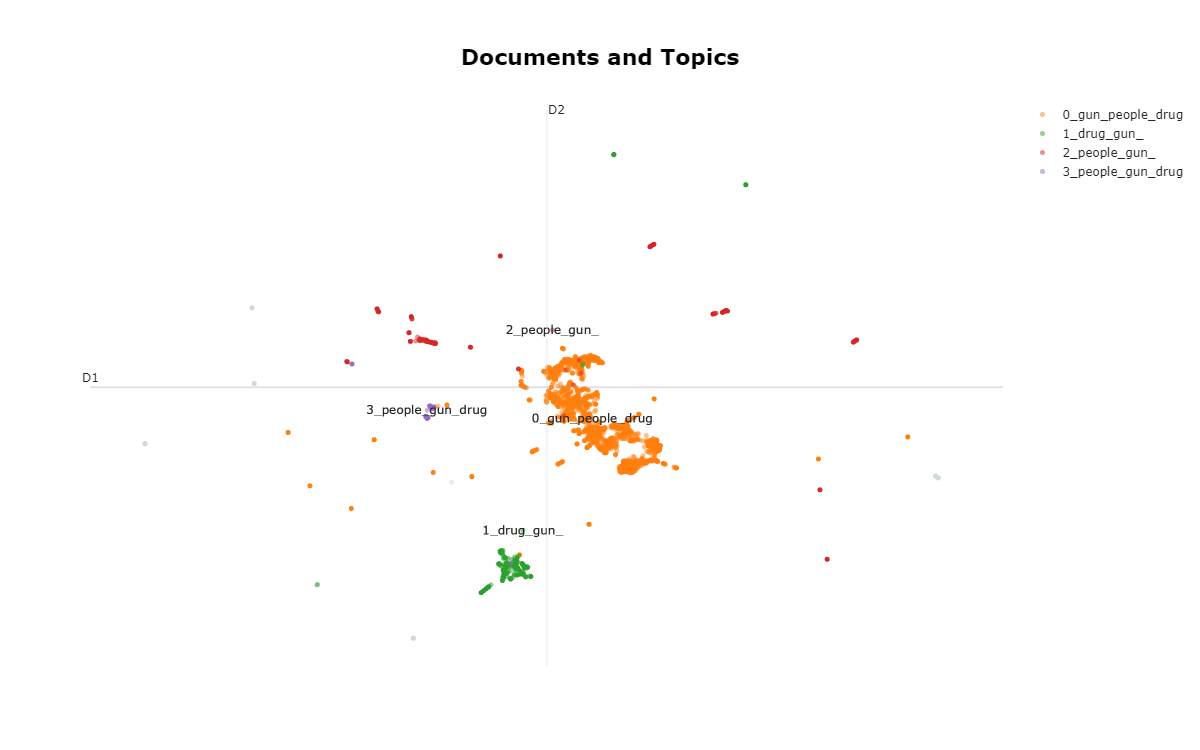

In [ ]:
topic_model.visualize_document_datamap(labels, embeddings=embedd)

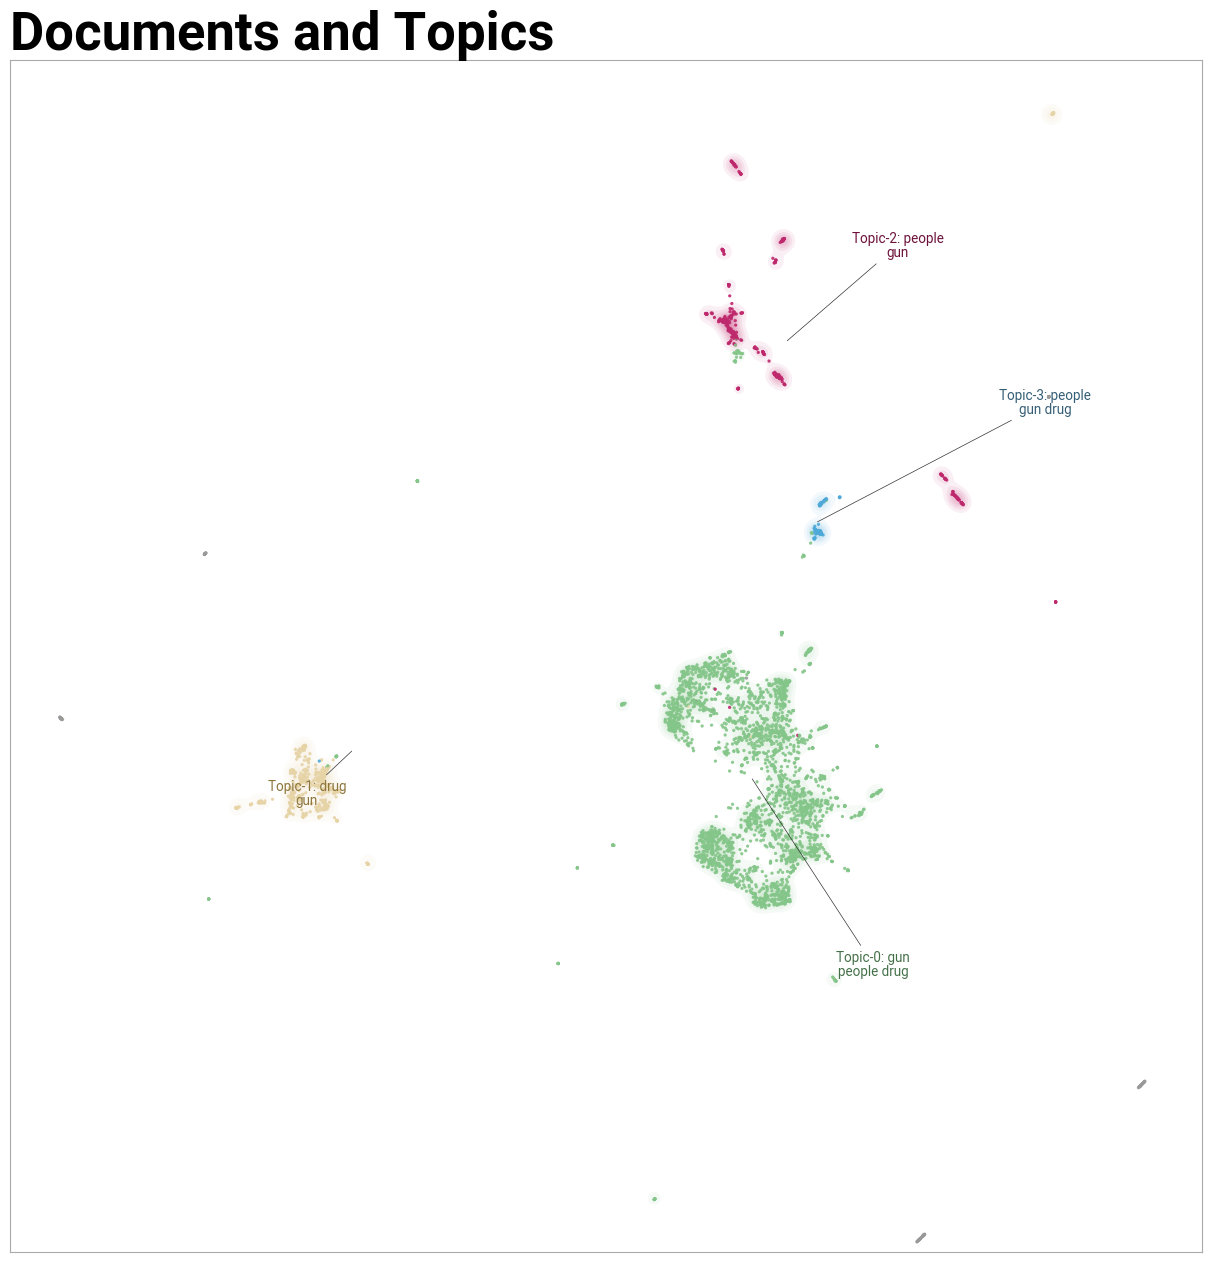

In [36]:
topic_model.visualize_term_rank(log_scale=True)

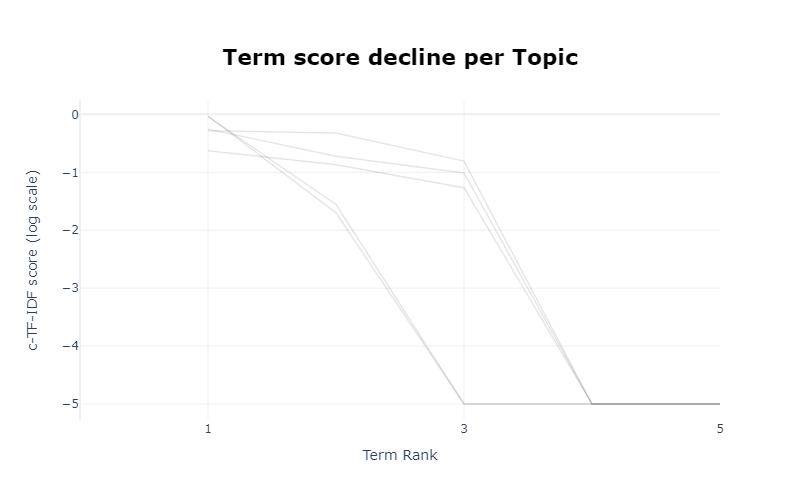

# Save Model

In [45]:
topic_model.save("Models/topic_visual_model_safetensors", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

In [ ]:
topic_model.push_to_hf_hub(
    repo_id="D0men1c0/ISSR_Visual_Model",
    save_embedding_model=embedding_model,
    save_ctfidf=True
)